# Analysing binned pseudorapidity

In [1]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt
import pickle

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
import torch_geometric
from torch_geometric.data import Data

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Locals

from prepareTracks import *
from nb_utils import *
from datasets import get_data_loaders
from trainers import get_trainer
import distributed

## Initial investigation

Set up the inital constraints and choose an event

In [2]:
pt_min, n_phi_sections, phi_slope_max, z0_max = 1, 1, 0.001, 150

In [27]:
event_prefix = 'event000001000'
hits, particles, truth = load_event(os.path.join('/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_100_events/', event_prefix), 
                                    parts=['hits', 'particles', 'truth'])
evtid = int(event_prefix[-9:])
hits = hits.assign(evtid=evtid)

Select end-cap volumes

In [28]:
# This is ONLY the end-cap
# vlids = [(9,2), (9,4), (9,6), (9,8), (9,10), (9,12), (9,14)]
# These are the other front detectors
#                     (14,2), (14,4), (14,6), (14,8), (14,10), (14,12),
#                     (18,2), (18,4), (18,6), (18,8), (18,10), (18,12)]
# These are the barrel volumes
vlids = [(8,2), (8,4), (8,6), (8,8),
             (13,2), (13,4), (13,6), (13,8),
             (17,2), (17,4)]
# eta_region = [0,0.2]

n_det_layers = len(vlids)
vlid_groups = hits.groupby(['volume_id', 'layer_id'])
hits = pd.concat([vlid_groups.get_group(vlids[i]).assign(layer=i)
                      for i in range(n_det_layers)])

In [29]:
pt = np.sqrt(particles.px**2 + particles.py**2)
particles = particles[pt > pt_min]
particles = particles.join(pd.DataFrame(pt, columns=["pt"]))

In [30]:
truth = (truth[['hit_id', 'particle_id']]
             .merge(particles[['particle_id', 'nhits', 'pt']], on='particle_id'))

In [31]:
theta_hits = np.arccos(hits.z / (hits.x**2 + hits.y**2 + hits.z**2)**(0.5))
eta_hits = -np.log(np.tan(theta_hits/2))
phi_hits = np.arctan2(hits.y, hits.x)
r_hits = np.sqrt(hits.x**2 + hits.y**2)

In [32]:
# Create big hits + truth D.F.
hits = (hits[['hit_id', 'x', 'y', 'z', 'layer', 'evtid']]
            .assign(r=r_hits, phi=phi_hits, eta=eta_hits)
            .merge(truth[['hit_id', 'particle_id', 'nhits', 'pt']], on='hit_id'))
# Remove duplicated
hits = hits.loc[
        hits.groupby(['particle_id', 'layer'], as_index=False).r.idxmin()
    ]
hits = hits[hits['nhits'] > 2]

In [89]:
hits = hits.assign(**{'{}'.format(k):v for k,v in zip(["C", "D","E","F","G"], np.zeros(len(hits)))})

In [102]:
for pid in pd.unique(hits['particle_id']):
    hits.loc[hits.particle_id == pid, ["C", "D", "E", "F", "G"]] = get_track_parameters(hits[hits.particle_id == pid]['x'].to_numpy(), hits[hits.particle_id == pid]['y'].to_numpy(), hits[hits.particle_id == pid]['z'].to_numpy())

Select certain eta region

In [9]:
eta_region = [3.2,4]
hits = hits[(hits.eta > eta_region[0]) & (hits.eta < eta_region[1])]
# hits = hits.sort_values(by='eta')

Organise into adjacent layers

In [10]:
l = np.arange(n_det_layers)
layer_pairs = np.stack([l[:-1], l[1:]], axis=1)

In [11]:
feature_names = ['r', 'phi', 'z']
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [12]:
graph, IDs = construct_graph(hits, layer_pairs=layer_pairs,
                              phi_slope_max=phi_slope_max, z0_max=z0_max,
                              feature_names=feature_names,
                              feature_scale=feature_scale)

## Convert Adjacency Matrix and Visualise

In [13]:
Ri_rows, Ri_cols = graph.Ri.nonzero()
Ro_rows, Ro_cols = graph.Ro.nonzero()
n_edges = Ri_cols.shape[0]
edge_index = np.zeros((2, n_edges), dtype=int)
edge_index[0, Ro_cols] = Ro_rows
edge_index[1, Ri_cols] = Ri_rows
print(len(graph.X), " hits and ", edge_index.shape[1], " edges")

634  hits and  524  edges


In [14]:
X, Y, edges, labels = graph.X, graph.y, edge_index, graph.y
X = X*feature_scale

0.8818340301513672


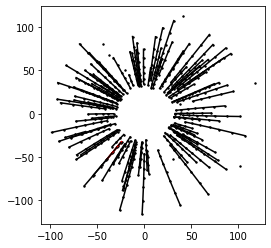

In [15]:
tic = tt()
draw_xy(X, edge_index, Y)
print(tt()-tic)

0.9848120212554932


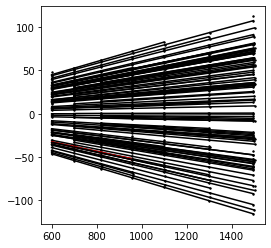

In [16]:
tic = tt()
draw_yz(X, edge_index, Y)
print(tt()-tic)

0.8288261890411377


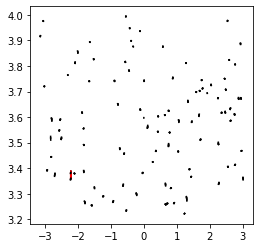

In [17]:
tic = tt()
draw_eta_phi(X, edge_index, Y)
print(tt()-tic)

0.9489381313323975


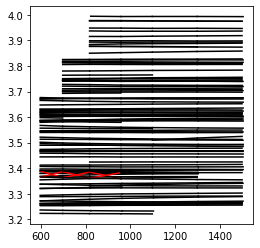

In [18]:
tic = tt()
draw_eta_z(X, edge_index, Y)
print(tt()-tic)

0.8636598587036133


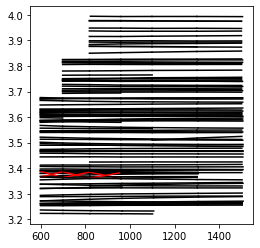

In [19]:
tic = tt()
draw_eta_r(X, edge_index, Y)
print(tt()-tic)

In [20]:
sorted_edges, sorted_Y = sort_eta(X, edge_index, Y)

In [24]:
sorted_edges[:,slice]

array([111, 112])

0.0493006706237793


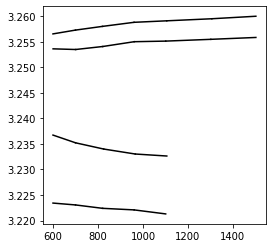

In [22]:
tic = time.time()
slice = 20
tracks = track_maker(sorted_edges[:,:slice], sorted_Y[:slice])
draw_eta_r(X, sorted_edges[:,:slice], sorted_Y[:slice])
print(time.time() - tic)

In [23]:
tracks

[[3, 2, 1, 0],
 [7, 6, 5, 4],
 [8, 9, 10, 11, 12, 13],
 [14, 15, 16, 17, 18, 19],
 []]

# Preparing track counter data

In [12]:
len(hits.particle_id.unique())

277

In [32]:
for i in range(10):
    for j in range(9):
        g = np.load('/global/cscratch1/sd/danieltm/ExaTrkX/counter_data/hitgraphs_small_000/event00000100'+str(i)+'_g00'+str(j)+'.npz')
        print(np.where(g['y']))

(array([17]),)
(array([11]),)
(array([13]),)
(array([15]),)
(array([15]),)
(array([21]),)
(array([18]),)
(array([28]),)
(array([14]),)
(array([13]),)
(array([16]),)
(array([9]),)
(array([14]),)
(array([8]),)
(array([9]),)
(array([11]),)
(array([11]),)
(array([15]),)
(array([21]),)
(array([29]),)
(array([27]),)
(array([19]),)
(array([23]),)
(array([17]),)
(array([17]),)
(array([22]),)
(array([23]),)
(array([10]),)
(array([14]),)
(array([11]),)
(array([21]),)
(array([20]),)
(array([28]),)
(array([19]),)
(array([11]),)
(array([16]),)
(array([12]),)
(array([25]),)
(array([18]),)
(array([17]),)
(array([26]),)
(array([29]),)
(array([28]),)
(array([28]),)
(array([17]),)
(array([13]),)
(array([12]),)
(array([22]),)
(array([21]),)
(array([15]),)
(array([14]),)
(array([15]),)
(array([16]),)
(array([11]),)
(array([23]),)
(array([23]),)
(array([22]),)
(array([25]),)
(array([24]),)
(array([27]),)
(array([17]),)
(array([17]),)
(array([19]),)
(array([13]),)
(array([22]),)
(array([17]),)
(array([17]),

In [21]:
g['y']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1.], dtype=float32)

# Training track counter

## Play area

In [3]:
A = torch.tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])

In [6]:
int(np.where(A)[0])

7

In [16]:
torch.argmax(A).unsqueeze(0).shape

torch.Size([1])

In [18]:
A.unsqueeze(0).shape

torch.Size([1, 41])

In [28]:
input = torch.randn(2, 3)
output = nn.LogSoftmax(input)

In [29]:
output

LogSoftmax()

In [33]:
e = torch.randn(33,1)
h = torch.randn(1,8)

In [36]:
(e*h).shape

torch.Size([33, 8])

In [38]:
print(e,h,h*e)

tensor([[-1.9664],
        [ 0.0821],
        [-0.3578],
        [ 0.5644],
        [ 0.7980],
        [-0.4230],
        [-1.0444],
        [ 0.1337],
        [-1.3731],
        [ 0.6058],
        [ 0.4436],
        [-1.1990],
        [-0.1769],
        [-0.4191],
        [-0.4110],
        [ 0.5188],
        [-0.6745],
        [ 1.0826],
        [-0.7400],
        [-0.0405],
        [ 0.9306],
        [-0.3912],
        [-1.2743],
        [ 1.6382],
        [-1.0518],
        [-0.0929],
        [ 0.8337],
        [-1.5664],
        [-0.6764],
        [-0.9818],
        [ 1.4599],
        [ 0.4732],
        [ 0.8265]]) tensor([[ 0.1322,  1.2162,  0.6082,  0.5639, -0.3008,  0.7964,  0.4999, -0.4438]]) tensor([[-0.2600, -2.3915, -1.1961, -1.1088,  0.5916, -1.5660, -0.9830,  0.8726],
        [ 0.0109,  0.0999,  0.0500,  0.0463, -0.0247,  0.0654,  0.0411, -0.0364],
        [-0.0473, -0.4352, -0.2176, -0.2018,  0.1076, -0.2850, -0.1789,  0.1588],
        [ 0.0746,  0.6864,  0.3433,  0.3182